In [ ]:
import os
os.chdir('..')

# Importación de librerias

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import lightgbm as lgb
from scripts import *
import pickle

In [2]:
plt.rcParams['figure.figsize'] = (12, 6)
sns.set(style='whitegrid', palette='muted', font_scale=1.1)
sns.set_context("notebook", rc={"figure.figsize": (12, 6)})

In [3]:
full_dataset_path = './datasets/full_dataset.parquet'
productos_a_predecir_path = './datasets/product_id_apredecir201912.txt'

# Cargar el modelo

In [4]:
df_full = pd.read_parquet(full_dataset_path)

In [5]:
df_full['cat1'] = df_full['cat1'].astype('category')
df_full['cat2'] = df_full['cat2'].astype('category')
df_full['cat3'] = df_full['cat3'].astype('category')
df_full['brand'] = df_full['brand'].astype('category')
df_full['sku_size'] = df_full['sku_size'].astype('category')

In [6]:
model = lgb.Booster(model_file='modelo_lgb.txt')
print("Modelo cargado exitosamente")

Modelo cargado exitosamente


In [7]:
future_periods = ['201912', '201911']
test_periods = ['201910']

In [8]:
df_full = df_full[~df_full['periodo'].isin(['201701', '201702', '201703', '201704', '201705', '201706', '201707', '201708', '201709', '201710', '201711', '201712'])]

In [9]:
df_train_test = df_full[~df_full['periodo'].isin(future_periods)]

In [10]:
df_train = df_train_test[~df_train_test['periodo'].isin(test_periods)]
df_test = df_train_test[df_train_test['periodo'].isin(test_periods)]
df_future = df_full[df_full['periodo'].isin(future_periods)]

# Hacer predicción

In [11]:
features = [col for col in df_train.columns if col not in ['target', 'weight_col', 'w_volumen', 'w_frecuencia', 'w_estabilidad', 'w_rank', 'w_tn', 'periodo', 'periodo_dt', 'year', 'customer_id', 'product_id', 'customer_id_limited', 'product_id_limited']]
categorical_cols = ['cat1', 'cat2', 'cat3', 'brand', 'sku_size', 'customer_id_limited_encoded', 'product_id_limited_encoded']

In [12]:
aux = df_full[(df_full['product_id_limited'] == '-1') & (df_full['customer_id_limited'] == '-1')].groupby(['customer_id', 'product_id', 'periodo'])[['customer_id', 'product_id', 'periodo', 'tn']].agg({'tn': 'mean'})
aux = aux[aux['tn'].notna()]
aux.reset_index()

,customer_id,product_id,periodo,tn
0,10090,20005,201801,-0.176275
1,10090,20005,201802,1.913812
2,10090,20005,201803,2.784681
3,10090,20005,201804,-0.176275
4,10090,20005,201805,1.565464
...,...,...,...,...
5643155,10604,21271,201904,-0.062257
5643156,10604,21271,201905,-0.062257
5643157,10604,21276,201903,-0.056134
5643158,10604,21276,201904,-0.056134


In [13]:
del df_full

In [14]:
X_train = df_train[features]
y_train = df_train['target']
X_test = df_test[features]
y_test = df_test['target']

In [15]:
y_pred_train = model.predict(X_train, num_iteration=model.best_iteration)

In [16]:
y_pred_test = model.predict(X_test, num_iteration=model.best_iteration)

In [17]:
y_pred_train = pd.DataFrame(y_pred_train, columns=['target_predicted'], index=X_train.index)
y_pred_test = pd.DataFrame(y_pred_test, columns=['target_predicted'], index=X_test.index)

df_train.loc[df_train.index, 'target_predicted'] = y_pred_train['target_predicted']
df_test.loc[df_test.index, 'target_predicted'] = y_pred_test['target_predicted']

C:\Users\dylan\AppData\Local\Temp\ipykernel_17404\1944381976.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[df_train.index, 'target_predicted'] = y_pred_train['target_predicted']
C:\Users\dylan\AppData\Local\Temp\ipykernel_17404\1944381976.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[df_test.index, 'target_predicted'] = y_pred_test['target_predicted']


# Predecir

In [18]:
X_pred = df_future[features]
X_pred

,tn,cat1,cat2,cat3,brand,sku_size,month,days_in_month,quarter,month_sin,...,tn_is_max_32,tn_is_max_33,tn_is_max_34,tn_is_max_35,tn_is_max_36,customer_id_limited_encoded,product_id_limited_encoded,lr_slope,lr_intercept,r_squared
34,12.193800,HC,ROPA LAVADO,Liquido,ARIEL,3000,11,30,4,-5.000000e-01,...,0,0,0,0,0,1,1,0.179702,5.903437,0.117251
35,9.250914,HC,ROPA LAVADO,Liquido,ARIEL,3000,12,31,4,-2.449294e-16,...,0,0,0,0,0,1,1,0.179702,5.903437,0.117251
70,39.629913,HC,ROPA LAVADO,Liquido,LIMPIEX,3000,11,30,4,-5.000000e-01,...,0,0,0,0,0,1,2,0.489256,5.009580,0.411381
71,24.105200,HC,ROPA LAVADO,Liquido,LIMPIEX,3000,12,31,4,-2.449294e-16,...,0,0,0,0,0,1,2,0.489256,5.009580,0.411381
106,13.524549,FOODS,ADEREZOS,Mayonesa,NATURA,475,11,30,4,-5.000000e-01,...,0,0,0,0,0,1,3,0.044716,10.201197,0.005090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15583641,-0.062352,PC,PIEL1,Cara,NIVEA,250,12,31,4,-2.449294e-16,...,0,0,0,0,0,239,0,0.000000,-0.062352,1.000000
15583642,-0.062257,REF,TE,Frutas,TWININGS,20,11,30,4,-5.000000e-01,...,0,0,0,0,0,239,0,0.000000,-0.062257,1.000000
15583643,-0.062257,REF,TE,Frutas,TWININGS,20,12,31,4,-2.449294e-16,...,0,0,0,0,0,239,0,0.000000,-0.062257,1.000000
15583644,-0.056134,PC,PIEL1,Cara,NIVEA,140,11,30,4,-5.000000e-01,...,0,0,0,0,0,239,0,0.000000,-0.056134,1.000000


In [19]:
predicciones = model.predict(X_pred, categorical_feature=categorical_cols)
predicciones

array([11.34982106, 11.46053175, 18.06276864, ..., -0.06866964,
       -0.06866964, -0.06866964])

In [20]:
predicciones = pd.DataFrame(predicciones, columns=['target_predicted'], index=X_pred.index)
predicciones

,target_predicted
34,11.349821
35,11.460532
70,18.062769
71,17.555545
106,11.365324
...,...
15583641,-0.068670
15583642,-0.068670
15583643,-0.068670
15583644,-0.068670


In [21]:
df_future.loc[predicciones.index, 'target'] = predicciones['target_predicted']
df_future.loc[predicciones.index, 'target_predicted'] = predicciones['target_predicted']
df_future

C:\Users\dylan\AppData\Local\Temp\ipykernel_17404\2917653618.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[11.34982106 11.46053175 18.06276864 ... -0.06866964 -0.06866964
 -0.06866964]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df_future.loc[predicciones.index, 'target'] = predicciones['target_predicted']


,customer_id,product_id,periodo,tn,cat1,cat2,cat3,brand,sku_size,periodo_dt,...,tn_is_max_36,customer_id_limited,product_id_limited,customer_id_limited_encoded,product_id_limited_encoded,target,lr_slope,lr_intercept,r_squared,target_predicted
34,10001,20001,201911,12.193800,HC,ROPA LAVADO,Liquido,ARIEL,3000,2019-11-01,...,0,10001,20001,1,1,11.349821,0.179702,5.903437,0.117251,11.349821
35,10001,20001,201912,9.250914,HC,ROPA LAVADO,Liquido,ARIEL,3000,2019-12-01,...,0,10001,20001,1,1,11.460532,0.179702,5.903437,0.117251,11.460532
70,10001,20002,201911,39.629913,HC,ROPA LAVADO,Liquido,LIMPIEX,3000,2019-11-01,...,0,10001,20002,1,2,18.062769,0.489256,5.009580,0.411381,18.062769
71,10001,20002,201912,24.105200,HC,ROPA LAVADO,Liquido,LIMPIEX,3000,2019-12-01,...,0,10001,20002,1,2,17.555545,0.489256,5.009580,0.411381,17.555545
106,10001,20003,201911,13.524549,FOODS,ADEREZOS,Mayonesa,NATURA,475,2019-11-01,...,0,10001,20003,1,3,11.365324,0.044716,10.201197,0.005090,11.365324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15583641,10618,21267,201912,-0.062352,PC,PIEL1,Cara,NIVEA,250,2019-12-01,...,0,10618,-1,239,0,-0.068670,0.000000,-0.062352,1.000000,-0.068670
15583642,10618,21271,201911,-0.062257,REF,TE,Frutas,TWININGS,20,2019-11-01,...,0,10618,-1,239,0,-0.068670,0.000000,-0.062257,1.000000,-0.068670
15583643,10618,21271,201912,-0.062257,REF,TE,Frutas,TWININGS,20,2019-12-01,...,0,10618,-1,239,0,-0.068670,0.000000,-0.062257,1.000000,-0.068670
15583644,10618,21276,201911,-0.056134,PC,PIEL1,Cara,NIVEA,140,2019-11-01,...,0,10618,-1,239,0,-0.068670,0.000000,-0.056134,1.000000,-0.068670


In [22]:
df = pd.concat([df_train, df_test, df_future])
df

,customer_id,product_id,periodo,tn,cat1,cat2,cat3,brand,sku_size,periodo_dt,...,tn_is_max_36,customer_id_limited,product_id_limited,customer_id_limited_encoded,product_id_limited_encoded,target,lr_slope,lr_intercept,r_squared,target_predicted
12,10001,20001,201801,2.440686,HC,ROPA LAVADO,Liquido,ARIEL,3000,2018-01-01,...,0,10001,20001,1,1,11.050138,0.179702,5.903437,0.117251,10.120762
13,10001,20001,201802,4.465077,HC,ROPA LAVADO,Liquido,ARIEL,3000,2018-02-01,...,0,10001,20001,1,1,6.779995,0.179702,5.903437,0.117251,9.380376
14,10001,20001,201803,11.050138,HC,ROPA LAVADO,Liquido,ARIEL,3000,2018-03-01,...,0,10001,20001,1,1,8.495625,0.179702,5.903437,0.117251,9.714350
15,10001,20001,201804,6.779995,HC,ROPA LAVADO,Liquido,ARIEL,3000,2018-04-01,...,0,10001,20001,1,1,4.666017,0.179702,5.903437,0.117251,9.631715
16,10001,20001,201805,8.495625,HC,ROPA LAVADO,Liquido,ARIEL,3000,2018-05-01,...,0,10001,20001,1,1,13.205526,0.179702,5.903437,0.117251,9.850259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15583641,10618,21267,201912,-0.062352,PC,PIEL1,Cara,NIVEA,250,2019-12-01,...,0,10618,-1,239,0,-0.068670,0.000000,-0.062352,1.000000,-0.068670
15583642,10618,21271,201911,-0.062257,REF,TE,Frutas,TWININGS,20,2019-11-01,...,0,10618,-1,239,0,-0.068670,0.000000,-0.062257,1.000000,-0.068670
15583643,10618,21271,201912,-0.062257,REF,TE,Frutas,TWININGS,20,2019-12-01,...,0,10618,-1,239,0,-0.068670,0.000000,-0.062257,1.000000,-0.068670
15583644,10618,21276,201911,-0.056134,PC,PIEL1,Cara,NIVEA,140,2019-11-01,...,0,10618,-1,239,0,-0.068670,0.000000,-0.056134,1.000000,-0.068670


# Obtener predicción de productos

In [23]:
productos_a_predecir_path = './datasets/product_id_apredecir201912.txt'

In [24]:
df_productos_a_predecir = pd.read_csv(productos_a_predecir_path, dtype={'product_id': 'str'})
df_productos_a_predecir

,product_id
0,20001
1,20002
2,20003
3,20004
4,20005
...,...
775,21263
776,21265
777,21266
778,21267


In [25]:
df = df[['customer_id', 'product_id', 'periodo', 'tn', 'target', 'target_predicted']]

In [26]:
tn_scaler_path = './scalers/scalers.pkl'

scalers = {}
with open(tn_scaler_path, 'rb') as f:
    scalers = pickle.load(f)

scaled_tn = []
for product_id, group in df.groupby('product_id'):
    group = group.copy()
    if product_id in scalers:
        scaler = scalers[product_id]
        group['tn_unscaled'] = scaler.inverse_transform(group[['tn']])
        group['target_unscaled'] = scaler.inverse_transform(group[['target']])
        group['target_predicted_unscaled'] = scaler.inverse_transform(group[['target_predicted']])
        aux['tn'] = scaler.inverse_transform(aux[['tn']])
    else:
        print(f"Warning: No scaler found for product {product_id}")
        group['tn_unscaled'] = 0
        group['target_unscaled'] = 0
        group['target_predicted_unscaled'] = 0
        aux['tn'] = 0
    scaled_tn.append(group)

df = pd.concat(scaled_tn, axis=0)

c:\Users\dylan\.conda\envs\default\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\dylan\.conda\envs\default\lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\dylan\.conda\envs\default\lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\dylan\.conda\envs\default\lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\dyl

In [27]:
df

,customer_id,product_id,periodo,tn,target,target_predicted,tn_unscaled,target_unscaled,target_predicted_unscaled
12,10001,20001,201801,2.440686,11.050138,10.120762,4.961857e+01,214.723369,196.900594
13,10001,20001,201802,4.465077,6.779995,9.380376,8.844065e+01,132.834189,182.702086
14,10001,20001,201803,11.050138,8.495625,9.714350,2.147234e+02,165.735076,189.106770
15,10001,20001,201804,6.779995,4.666017,9.631715,1.328342e+02,92.294097,187.522052
16,10001,20001,201805,8.495625,13.205526,9.850259,1.657351e+02,256.057596,191.713106
...,...,...,...,...,...,...,...,...,...
15493969,10599,21276,201912,-0.056134,-0.068670,-0.068670,-4.436786e-12,-0.000023,-0.000023
15547346,10606,21276,201911,-0.056134,-0.070108,-0.070108,-4.436786e-12,-0.000026,-0.000026
15547347,10606,21276,201912,-0.056134,-0.070108,-0.070108,-4.436786e-12,-0.000026,-0.000026
15583644,10618,21276,201911,-0.056134,-0.068670,-0.068670,-4.436786e-12,-0.000023,-0.000023


In [28]:
df['periodo'] = df['periodo'].astype(str)

In [29]:
df.loc[df['target_predicted_unscaled'] < 0, 'target_predicted_unscaled'] = 0
df

,customer_id,product_id,periodo,tn,target,target_predicted,tn_unscaled,target_unscaled,target_predicted_unscaled
12,10001,20001,201801,2.440686,11.050138,10.120762,4.961857e+01,214.723369,196.900594
13,10001,20001,201802,4.465077,6.779995,9.380376,8.844065e+01,132.834189,182.702086
14,10001,20001,201803,11.050138,8.495625,9.714350,2.147234e+02,165.735076,189.106770
15,10001,20001,201804,6.779995,4.666017,9.631715,1.328342e+02,92.294097,187.522052
16,10001,20001,201805,8.495625,13.205526,9.850259,1.657351e+02,256.057596,191.713106
...,...,...,...,...,...,...,...,...,...
15493969,10599,21276,201912,-0.056134,-0.068670,-0.068670,-4.436786e-12,-0.000023,0.000000
15547346,10606,21276,201911,-0.056134,-0.070108,-0.070108,-4.436786e-12,-0.000026,0.000000
15547347,10606,21276,201912,-0.056134,-0.070108,-0.070108,-4.436786e-12,-0.000026,0.000000
15583644,10618,21276,201911,-0.056134,-0.068670,-0.068670,-4.436786e-12,-0.000023,0.000000


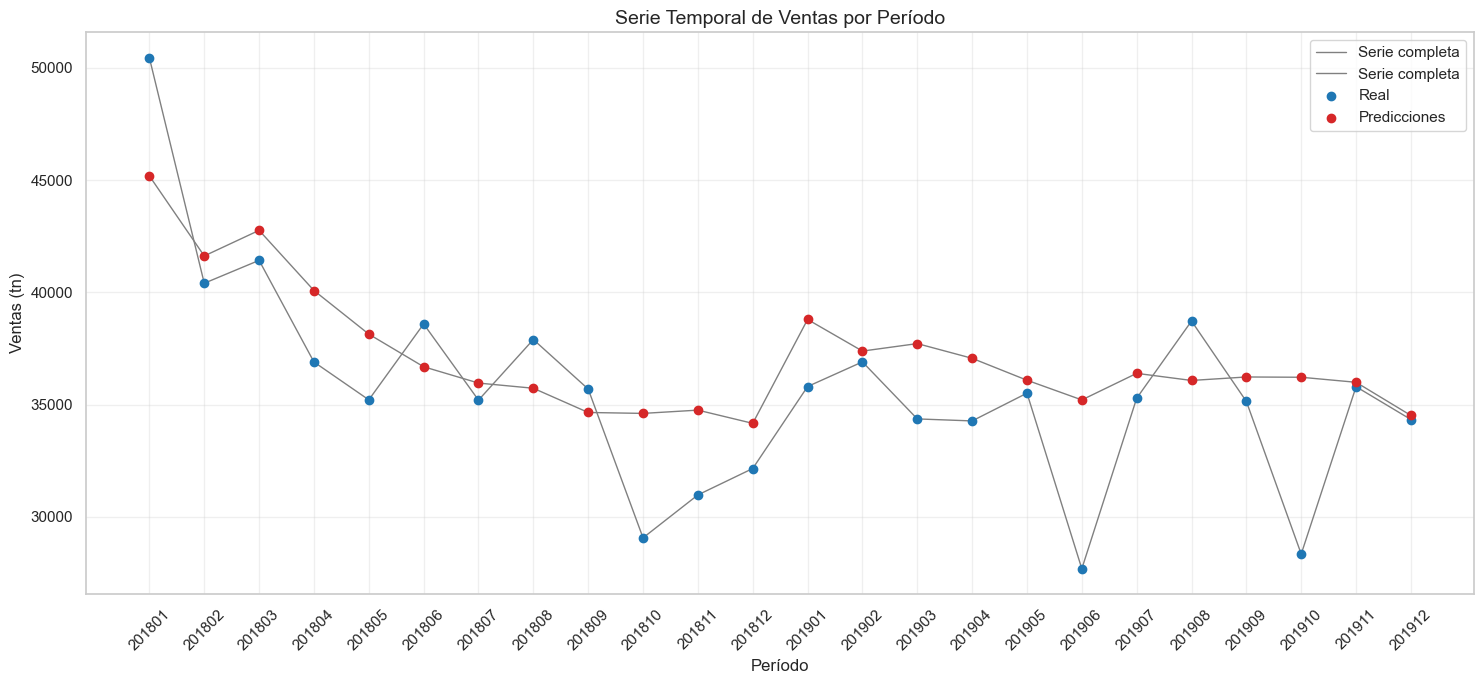

In [30]:
df_aux = df.groupby('periodo')[['tn_unscaled', 'target_unscaled', 'target_predicted_unscaled']].sum()

plt.figure(figsize=(15, 7))

plt.plot(df_aux.index, df_aux['target_unscaled'], color='gray', linewidth=1, label='Serie completa')
plt.plot(df_aux.index, df_aux['target_predicted_unscaled'], color='gray', linewidth=1, label='Serie completa')

plt.scatter(df_aux.index, df_aux['target_unscaled'], color='tab:blue', label='Real', zorder=3)
plt.scatter(df_aux.index, df_aux['target_predicted_unscaled'], color='tab:red', label='Predicciones', zorder=3)

plt.title('Serie Temporal de Ventas por Período', fontsize=14)
plt.xlabel('Período', fontsize=12)
plt.ylabel('Ventas (tn)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

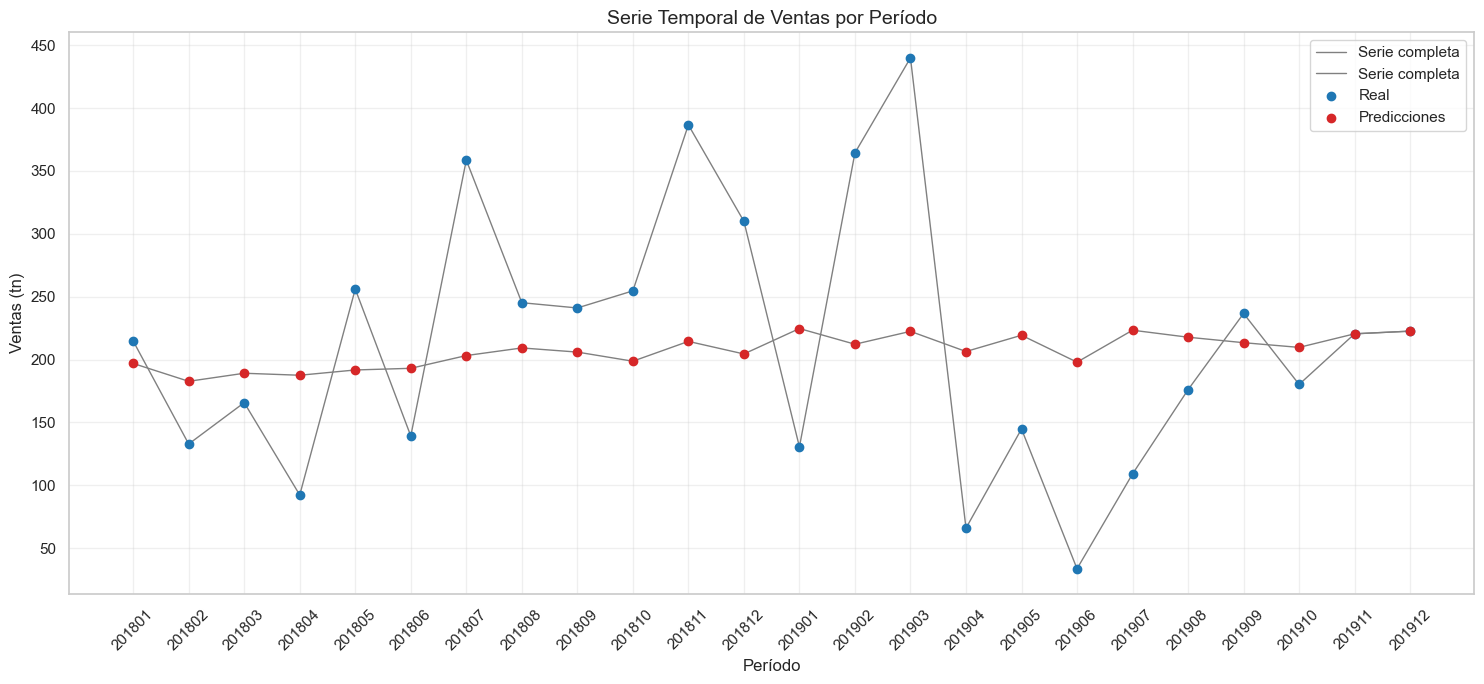

In [31]:
df_aux = df[(df['customer_id'] == '10001') & (df['product_id'] == '20001')].groupby('periodo')[['tn_unscaled', 'target_unscaled', 'target_predicted_unscaled']].sum()

plt.figure(figsize=(15, 7))

plt.plot(df_aux.index, df_aux['target_unscaled'], color='gray', linewidth=1, label='Serie completa')
plt.plot(df_aux.index, df_aux['target_predicted_unscaled'], color='gray', linewidth=1, label='Serie completa')

plt.scatter(df_aux.index, df_aux['target_unscaled'], color='tab:blue', label='Real', zorder=3)
plt.scatter(df_aux.index, df_aux['target_predicted_unscaled'], color='tab:red', label='Predicciones', zorder=3)

plt.title('Serie Temporal de Ventas por Período', fontsize=14)
plt.xlabel('Período', fontsize=12)
plt.ylabel('Ventas (tn)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [32]:
future_periods = df['periodo'].unique()[-1:]

df_productos_a_predecir = pd.read_csv(productos_a_predecir_path, dtype={'product_id': 'str'})
df_productos_a_predecir = df_productos_a_predecir.drop_duplicates()

df_output = df[
    (df['product_id'].isin(df_productos_a_predecir['product_id'])) & 
    (df['periodo'].isin(future_periods))
]

df_output['product_id'] = df_output['product_id'].astype(str)

df_output

C:\Users\dylan\AppData\Local\Temp\ipykernel_17404\1380985276.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_output['product_id'] = df_output['product_id'].astype(str)


,customer_id,product_id,periodo,tn,target,target_predicted,tn_unscaled,target_unscaled,target_predicted_unscaled
35,10001,20001,201912,9.250914,11.460532,11.460532,1.802194e+02,222.593563,222.593563
31634,10002,20001,201912,5.763028,2.245026,2.245026,1.133316e+02,45.866377,45.866377
63233,10003,20001,201912,5.186484,7.732428,7.732428,1.022752e+02,151.099129,151.099129
94832,10004,20001,201912,1.660045,8.151005,8.151005,3.464810e+01,159.126260,159.126260
126431,10005,20001,201912,0.875548,0.630522,0.630522,1.960368e+01,14.904774,14.904774
...,...,...,...,...,...,...,...,...,...
15412248,10582,21276,201912,-0.056134,-0.015652,-0.015652,-4.436786e-12,0.000075,0.000075
15418864,10584,21276,201912,-0.056134,-0.070108,-0.070108,-4.436786e-12,-0.000026,0.000000
15493969,10599,21276,201912,-0.056134,-0.068670,-0.068670,-4.436786e-12,-0.000023,0.000000
15547347,10606,21276,201912,-0.056134,-0.070108,-0.070108,-4.436786e-12,-0.000026,0.000000


In [33]:
df_output_agrupado = df_output.groupby(['product_id'])[['target_predicted_unscaled']].sum()
df_output_agrupado

,target_predicted_unscaled
product_id,
20001,1535.472977
20002,1268.892433
20003,831.848250
20004,672.822891
20005,637.657888
...,...
21263,0.034899
21265,0.064624
21266,0.070753


In [34]:
df_output_agrupado = df_output_agrupado.rename(columns={'target_predicted_unscaled': 'tn'})
df_output_agrupado

,tn
product_id,
20001,1535.472977
20002,1268.892433
20003,831.848250
20004,672.822891
20005,637.657888
...,...
21263,0.034899
21265,0.064624
21266,0.070753


In [35]:
df_output_agrupado.to_csv('./output.csv', index=True)